<a href="https://csdms.colorado.edu/wiki/ESPIn2020"><img style="float: center; width: 75%" src="../espin/media/ESPIn.png"></a>

# Frost-Cracking 2D

We will set up a model to estimate frost-cracking intensities. To this end, we assume that heat is only transported through conduction and bedrock temperatures can therefore be assessed solving the diffusion equation with (transient) bedrock surface temperature as the boundary condition.

THIS IS CHANGED

## Initializations

First, we import the necessary modules:

In [1]:
import numpy as np
from matplotlib import pyplot as plt
from landlab import RasterModelGrid
from landlab import imshow_grid

Now we need to set up the computational grid. We will use a raster. `Lx` and `Ly` are the depth and height of the bedrock domain, respectively.

In [2]:
rows = 10
cols = 30
dx = 100 # in m
rg = RasterModelGrid((rows, cols), xy_spacing=dx)

Assign fields.

In [3]:
dem = rg.add_zeros('topographic__elevation', at='node')
Ts_ini = rg.add_zeros('temperature_surface_ini', at='node')

We will simply assume a vertical wall and assign a slope along the columns of `dem`.

/Users/hirschbe/opt/anaconda3/envs/espin/lib/python3.9/site-packages/landlab/plot/imshow.py:267: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. This has been deprecated since 3.3 and in 3.6, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = mpl.cm.get_cmap("pink").copy()
  cmap.set_bad(color=color_for_closed)
/Users/hirschbe/opt/anaconda3/envs/espin/lib/python3.9/site-packages/landlab/plot/imshow.py:307: MatplotlibDeprecationWarning: The 'norm' parameter to Colorbar has no effect because it is overridden by the mappable; it is deprecated since 3.3 and will be removed two minor releases later.
  cb = plt.colorbar(norm=norm, shrink=shrink)


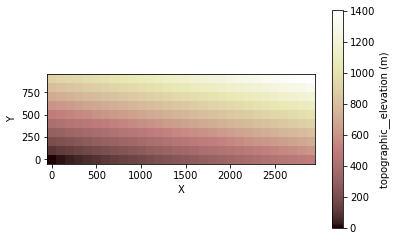

In [4]:
slope = np.deg2rad(10) # degrees
for i in range(rows):
    dem[i*cols:(i+1)*cols] = i * dx

dz = np.arange(0, np.sin(slope)*(dx*cols), np.sin(slope)*(dx*cols)/cols)
for i in range(rows):
    dem[i*cols:(i+1)*cols] += dz
    
imshow_grid(rg, 'topographic__elevation', colorbar_label='topographic__elevation (m)')

The initial surface temperature `Ts_init` needs to be extrapolated. Assumptions:
 
 - `Ts`is sinusoidal
 - lapse rate `lr` = 6 °C/km.
 - Provide the temperature mean `Tm` and the amplitude `Ta` and the representative elevation `T_ele`

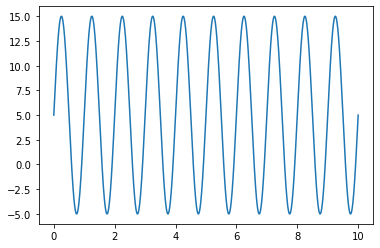

In [5]:
Tm = 5
Ta = 10
lr = 6
T_ele = 700

one_day = 60*60*24
one_year = 365 * one_day
timestep = 0.5 * 60*60 # 0.5 hours
tend = 10 * one_year
period = one_year
t = np.arange(0, tend, timestep)

Ts = Tm + Ta * np.sin(2*np.pi * t/period)
plt.plot(t/one_year,Ts)

array([ 0.])

/Users/hirschbe/opt/anaconda3/envs/espin/lib/python3.9/site-packages/landlab/plot/imshow.py:267: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. This has been deprecated since 3.3 and in 3.6, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = mpl.cm.get_cmap("pink").copy()
  cmap.set_bad(color=color_for_closed)
/Users/hirschbe/opt/anaconda3/envs/espin/lib/python3.9/site-packages/landlab/plot/imshow.py:307: MatplotlibDeprecationWarning: The 'norm' parameter to Colorbar has no effect because it is overridden by the mappable; it is deprecated since 3.3 and will be removed two minor releases later.
  cb = plt.colorbar(norm=norm, shrink=shrink)


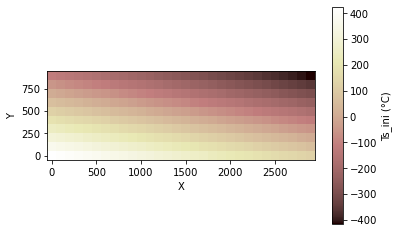

In [6]:
dz = dem - T_ele
Ts_ini[:] = Tm - dz * lr/(1000/dx)
imshow_grid(rg, 'temperature_surface_ini', colorbar_label='Ts_ini (°C)')

## The Frost-cracking model

First, we set up the model. This is based on the lab [Simulation of ground temperature profile evolution](https://csdms.rc.colorado.edu/user/jhirschberg/notebooks/learning-with-1d-models/ground_temperature_profile.ipynb).

In [7]:
class HeatConductionSimulator(object):

    def __init__(self,
                 surface_temp,
                 time,
                 thermal_diffusivity=1.0e-6,
                 profile_depth=10.0,
                 geotherm=0.025,
                 num_nodes=101,
                 diffusion_number=0.2,
                ):
        """Initialize the HeatConductionSimulator.

        Parameters
        ----------
        surface_temp: float
            Time series of temperature, degrees C
        time: float
            Time array, seconds
        thermal_diffusivity: float
            Thermal diffusivity, in m2/s (default 10^-6)
        profile_depth: float
            Depth of profile, m (default 1 m)
        geotherm: float
            Background geothermal gradient (default 0.025 deg C / m)
        num_nodes: int
            Number of nodes (default 101)
        diffusion_number: float
            Dimensionless diffusion number = D dt / dz^2 (default 0.2)
        """
        self.surface_temp = surface_temp
        self.time = time
        self.profile_depth = profile_depth
        self.alpha = diffusion_number  # must be <= 1/2 for numerical stability
        self.thermal_diffusivity = thermal_diffusivity
        
        self.dz = profile_depth / (num_nodes - 1)
        self.timestep_duration_should = self.alpha * self.dz * self.dz / thermal_diffusivity
        self.timestep_duration_is = time[1]-time[0]
        assert self.timestep_duration_should > self.timestep_duration_is
        
        self.depth = np.linspace(0, profile_depth, num_nodes)
        self.temp = surface_temp[0] + geotherm * self.depth
        self.current_time = 0.0
        self.current_timestep = 0
        self.max_act_layer_depth = 0.0    
        
    def run_one_step(self):
        """Advance for one time step"""
        self.temp[0] = self.surface_temp[self.current_timestep]
        q = -self.thermal_diffusivity * np.diff(self.temp)/self.dz    
        self.temp[1:-1] = self.temp[1:-1] - self.timestep_duration_is*np.diff(q)/self.dz  
        self.current_time += self.timestep_duration_is
        self.current_timestep += 1
        
        #self.temp[0] = (self.surface_temp + 
        #                self.amplitude * np.sin(2.0 * np.pi * self.current_time / self.period))
        #self.temp[1:-1] += self.alpha * (self.temp[2:] - 2 * self.temp[1:-1] + self.temp[:-2])
        #self.current_time += self.timestep_duration

    def run_all_steps(self, n):
        """Advance for all time steps"""
        for i in range(len(surface_temp)):
            self.run_one_step()

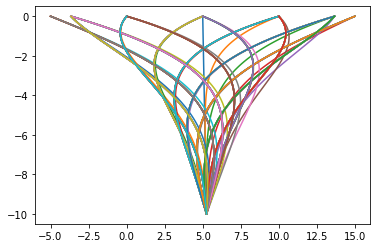

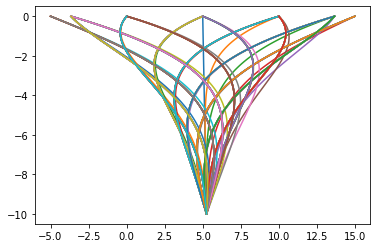

In [12]:
from IPython import display
hcs = HeatConductionSimulator(surface_temp = Ts, time = t)
i = 0
while i<len(Ts):
    hcs.run_one_step()
    if i%(8760*2/12) == 0:
        plt.plot(hcs.temp, -hcs.depth)
        display.clear_output(wait=True)
        display.display(plt.gcf())
    i+=1

In [35]:
class FROST_CRACK_2D():
    
    def __init__(self,
                 path_temp_file,
                 grid_cols=30,
                 grid_rows=10,
                 grid_dx=100,
                 grid_slope=10,
                 use_dem = False,
                 dem_path = '',
                 temp_lapse_rate = 6,
                 thermal_diffusivity=1.0e-6,
                 profile_depth=10.0,
                 geotherm=0.025,
                 num_nodes=101,
                ):
        """Initialize the HeatConductionSimulator.

        Parameters
        ----------
        path_temp_file: string
            path to netcdf file with temperature
        surface_temp: float
            Time series of temperature, degrees C
        time: float
            Time array, seconds
        thermal_diffusivity: float
            Thermal diffusivity, in m2/s (default 10^-6)
        profile_depth: float
            Depth of profile, m (default 1 m)
        geotherm: float
            Background geothermal gradient (default 0.025 deg C / m)
        num_nodes: int
            Number of nodes (default 101)
        diffusion_number: float
            Dimensionless diffusion number = D dt / dz^2 (default 0.2)
        """
        
        
        
        ### LOAD NETCDF FILE
        
        t = ... # time
        Ts = ... # surface temp
        T_ele = ... # 
        
        
        ######## TEMPORARY
        Tm = 5
        Ta = 10
        lr = 6
        T_ele = 700

        one_day = 60*60*24
        one_year = 365 * one_day
        timestep = 0.5 * 60*60 # 0.5 hours
        tend = 10 * one_year
        period = one_year
        t = np.arange(0, tend, timestep)
        Ts = Tm + Ta * np.sin(2*np.pi * t/period)
        
        #########
        
        self.time = t
        self.Ts0 = Ts
        self.Ts0_ele = T_ele
        self.dz = profile_depth / (num_nodes - 1)
        self.timestep_duration_should = self.dz * self.dz /(2*thermal_diffusivity) # Von Neumann stability
        self.timestep_duration_is = time[1]-time[0]
        assert self.timestep_duration_should > self.timestep_duration_is
        self.depth = np.linspace(0, profile_depth, num_nodes)
        self.temp = surface_temp[0] + geotherm * self.depth # this is the initial temperature profile
        self.temp_lapse_rate = temp_lapse_rate
        self.current_time = 0.0
        self.current_timestep = 0
        self.max_act_layer_depth = 0.0
        
        ### SETUP GRID
        if use_dem:
            # load dem with path
            pass
        else:
            rg = RasterModelGrid((grid_rows, grid_cols), xy_spacing=grid_dx)
            
            slope = np.deg2rad(grid_slope) # degrees
            for i in range(rows):
                dem[i*cols:(i+1)*cols] = i * dx

            dz = np.arange(0, np.sin(slope)*(dx*cols), np.sin(slope)*(dx*cols)/cols)
            for i in range(rows):
                dem[i*cols:(i+1)*cols] += dz
                    
            dem = rg.add_zeros('topographic__elevation', at='node')
            Ts_boundary = rg.add_zeros('temperature_surface_boundary', at='node')
            
            self.grid_rows = grid_rows
            self.grid_cols = grid_cols
            self.grid_dx = grid_dx
            self.grid_slope = grid_slope
            self.dem = dem
            self.Ts_boundary = Ts_boundary
            self.grid = rg
        
        # INITIALIZE TEMPERATURE
        
            
    def interp_Ts(self):
        dz = self.dem - self.Ts0_ele
        self.Ts_boundary[:] = Tm - dz * lr/(1000/dx)
        
    def run_one_step(self):
        """Advance for one time step"""
        self.temp[0] = self.surface_temp[self.current_timestep]
        q = -self.thermal_diffusivity * np.diff(self.temp)/self.dz    
        self.temp[1:-1] = self.temp[1:-1] - self.timestep_duration_is*np.diff(q)/self.dz  
        self.current_time += self.timestep_duration_is
        self.current_timestep += 1


In [36]:
fc = FROST_CRACK_2D('')

AttributeError: 'FROST_CRACK_2D' object has no attribute 'alpha'

In [40]:
100**2 /(10**-6)/2

5000000000.0

57870.37037037037